In [1]:
# ==============================================================================
# Cell 1: Setup, Configuration, and Imports
# ==============================================================================
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler
from timm.data.mixup import Mixup
from timm.loss import SoftTargetCrossEntropy
import timm

from sklearn.metrics import classification_report, confusion_matrix

# Suppress warnings for a cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

def seed_everything(seed=42):
    """Sets a fixed seed for reproducibility across all libraries."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
seed_everything(SEED)

# --- Configuration ---
DATA_DIR = "/kaggle/input/sports-102/Sports102_V2"
OUTPUT_DIR = "/kaggle/working/eva02_unimodal_outputs_224px"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224
# WARNING: A batch size of 32 is very likely to cause an OutOfMemoryError.
# It is recommended to start with 16 and increase cautiously if memory allows.
BATCH_SIZE = 32
NUM_EPOCHS = 50 
INIT_LR = 1e-5
WEIGHT_DECAY = 0.05
NUM_WORKERS = 2

# --- Hyperparameters ---
MIXUP_ALPHA = 0.8
CUTMIX_ALPHA = 1.0
LABEL_SMOOTHING = 0.1
CONTRASTIVE_LOSS_WEIGHT = 0.1

print(f"Device: {DEVICE}")
print(f"Available GPUs: {torch.cuda.device_count()}")
print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Using timm version: {timm.__version__}")



/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Device: cuda
Available GPUs: 2
Image Size: 224x224
Batch Size: 32
Using timm version: 1.0.19


In [2]:
# ==============================================================================
# Cell 2: Data Loading and Augmentations
# ==============================================================================

class TwoRegionRandomErasing:
    """
    Custom transform that applies torchvision's RandomErasing twice,
    as described in the SYD-Net paper to improve performance by occluding
    two distinct regions of the image.
    """
    def __init__(self, p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random'):
        # Each eraser instance will be called with a probability 'p'
        self.eraser = transforms.RandomErasing(p=1.0, scale=scale, ratio=ratio, value=value)
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            img = self.eraser(img)
        if random.random() < self.p:
            img = self.eraser(img)
        return img

# Define the full augmentation pipeline for the training set
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.RandomAffine(0, scale=(0.75, 1.25)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # Apply the custom two-region erasing from the SYD-Net paper
    TwoRegionRandomErasing(p=0.5, value='random'),
])

# Define a simpler transform for validation and testing
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
full_train_dataset_with_aug = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_transform)
full_train_dataset_no_aug = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=test_transform)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=test_transform)

# Create an 80/20 train/validation split for robust evaluation
train_size = int(0.8 * len(full_train_dataset_with_aug))
val_size = len(full_train_dataset_with_aug) - train_size

generator = torch.Generator().manual_seed(SEED)
train_indices, val_indices = random_split(range(len(full_train_dataset_with_aug)), [train_size, val_size], generator=generator)

train_dataset = Subset(full_train_dataset_with_aug, train_indices)
val_dataset = Subset(full_train_dataset_no_aug, val_indices)

NUM_CLASSES = len(full_train_dataset_with_aug.classes)
print(f"Number of classes: {NUM_CLASSES}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Setup the Mixup/CutMix function
mixup_fn = Mixup(
    mixup_alpha=MIXUP_ALPHA,
    cutmix_alpha=CUTMIX_ALPHA,
    label_smoothing=LABEL_SMOOTHING,
    num_classes=NUM_CLASSES
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


Number of classes: 102
Training samples: 7422
Validation samples: 1856
Test samples: 4319


In [3]:
# ==============================================================================
# Cell 3: Simplified EVA-02 Model Architecture
# ==============================================================================

class EVA02_Model(nn.Module):
    """
    A simplified, unimodal architecture using only the EVA-02 backbone.
    The knowledge fusion components (BEiT, CLIP, CrossAttention) have been removed.
    """
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # --- 1. EVA-02 Backbone ---
        # FINAL FIX: Removed the specific weight tag. timm will now automatically 
        # load the default best weights for this model when pretrained=True.
        self.backbone = timm.create_model(
            'eva02_large_patch14_224', 
            pretrained=pretrained
        )
        self.backbone.head = nn.Identity()
        backbone_dim = self.backbone.embed_dim

        # --- 2. Classification and Contrastive Heads ---
        # The heads remain the same, operating on the output of the backbone.
        self.head = nn.Linear(backbone_dim, num_classes)
        self.contrastive_head = nn.Sequential(
            nn.LayerNorm(backbone_dim),
            nn.Linear(backbone_dim, 128) # Project to a 128-dim space for contrastive loss
        )

    def forward(self, x):
        # The forward pass is now much simpler.
        # 1. Extract features from the EVA-02 backbone.
        features = self.backbone.forward_features(x)

        # 2. Global average pooling to get a single vector representation.
        pooled_output = features.mean(dim=1)

        # 3. Pass the pooled features through the two heads.
        logits = self.head(pooled_output)
        contrastive_features = self.contrastive_head(pooled_output)

        return logits, F.normalize(contrastive_features, dim=1)

# Instantiate the simplified model and move it to the GPU
model = EVA02_Model(num_classes=NUM_CLASSES, pretrained=True)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
model.to(DEVICE)
print("✅ Simplified EVA-02 Model architecture created successfully.")


model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

Using 2 GPUs!
✅ Simplified EVA-02 Model architecture created successfully.


In [4]:
# ==============================================================================
# Cell 4: Loss Functions
# ==============================================================================

class SupConLoss(nn.Module):
    """Supervised Contrastive Loss from https://arxiv.org/pdf/2004.11362.pdf."""
    def __init__(self, temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        batch_size = features.shape[0]
        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        anchor_dot_contrast = torch.div(torch.matmul(features, features.T), self.temperature)
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        logits_mask = torch.scatter(
            torch.ones_like(mask), 1,
            torch.arange(batch_size).view(-1, 1).to(features.device), 0
        )
        mask = mask * logits_mask
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-6)

        # Handle cases where a class has only one sample in the batch
        mask_sum = mask.sum(1)
        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask_sum + 1e-6)

        loss = -mean_log_prob_pos.mean()
        return loss

# 1. Classification Loss (compatible with Mixup/CutMix)
classification_loss_fn = SoftTargetCrossEntropy().to(DEVICE)

# 2. Contrastive Loss (to create better feature separation)
contrastive_loss_fn = SupConLoss().to(DEVICE)

print("✅ Dual-component loss functions created successfully.")


✅ Dual-component loss functions created successfully.


In [5]:
# ==============================================================================
# Cell 5: Training & Validation Script
# ==============================================================================

print("\n--- Starting Final Training Run (224px, Unimodal) ---")

# --- Setup model and training components ---
optimizer = optim.AdamW(model.parameters(), lr=INIT_LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-7)
scaler = torch.amp.GradScaler('cuda')

best_val_acc = 0.0
best_model_path = os.path.join(OUTPUT_DIR, "best_model.pth")

for epoch in range(NUM_EPOCHS):
    # ===================================
    #              TRAINING
    # ===================================
    model.train()
    total_train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{NUM_EPOCHS}")
    for images, labels in pbar:
        original_labels = labels.clone().to(DEVICE)
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        images, labels = mixup_fn(images, labels)

        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            logits, features = model(images)
            loss_cls = classification_loss_fn(logits, labels)
            loss_con = contrastive_loss_fn(features, original_labels)
            loss = loss_cls + (loss_con * CONTRASTIVE_LOSS_WEIGHT)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_train_loss += loss.item()
        train_total += original_labels.size(0)
        train_correct += (logits.argmax(1) == original_labels).sum().item()
        
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = (train_correct / train_total) * 100

    # ===================================
    #             VALIDATION
    # ===================================
    model.eval()
    total_val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            with torch.amp.autocast('cuda'):
                logits, _ = model(images)
                # FIXED: Manually one-hot encode the integer labels for the loss function
                # The .float() is necessary for the multiplication inside the loss function.
                target = F.one_hot(labels, num_classes=NUM_CLASSES).float()
                loss = classification_loss_fn(logits, target)
            
            total_val_loss += loss.item()
            val_total += labels.size(0)
            val_correct += (logits.argmax(1) == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = (val_correct / val_total) * 100
    
    # ===================================
    #          EPOCH SUMMARY
    # ===================================
    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Train Acc: {train_acc:.2f}% | "
        f"Val Loss: {avg_val_loss:.4f} | "
        f"Val Acc: {val_acc:.2f}%"
    )

    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"  ✨ Final best model saved with Val Acc: {best_val_acc:.2f}%")

print("\n--- ✅ Training Complete ---")



--- Starting Final Training Run (224px, Unimodal) ---


Training Epoch 1/50: 100%|██████████| 232/232 [04:49<00:00,  1.25s/it, loss=2.5577]


Epoch 1/50 | Train Loss: 3.1226 | Train Acc: 40.84% | Val Loss: 0.3206 | Val Acc: 96.61%
  ✨ Final best model saved with Val Acc: 96.61%


Training Epoch 2/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=1.2325]


Epoch 2/50 | Train Loss: 2.1582 | Train Acc: 57.37% | Val Loss: 0.2300 | Val Acc: 98.44%
  ✨ Final best model saved with Val Acc: 98.44%


Training Epoch 3/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=2.7872]


Epoch 3/50 | Train Loss: 2.0839 | Train Acc: 57.11% | Val Loss: 0.1942 | Val Acc: 99.03%
  ✨ Final best model saved with Val Acc: 99.03%


Training Epoch 4/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=1.9390]


Epoch 4/50 | Train Loss: 2.0155 | Train Acc: 60.20% | Val Loss: 0.1950 | Val Acc: 99.08%
  ✨ Final best model saved with Val Acc: 99.08%


Training Epoch 5/50: 100%|██████████| 232/232 [04:47<00:00,  1.24s/it, loss=1.8062]


Epoch 5/50 | Train Loss: 1.8751 | Train Acc: 57.37% | Val Loss: 0.2234 | Val Acc: 98.76%


Training Epoch 6/50: 100%|██████████| 232/232 [04:47<00:00,  1.24s/it, loss=2.0952]


Epoch 6/50 | Train Loss: 1.8678 | Train Acc: 61.34% | Val Loss: 0.1776 | Val Acc: 98.92%


Training Epoch 7/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=2.1331]


Epoch 7/50 | Train Loss: 1.8661 | Train Acc: 60.66% | Val Loss: 0.2096 | Val Acc: 99.19%
  ✨ Final best model saved with Val Acc: 99.19%


Training Epoch 8/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=1.9250]


Epoch 8/50 | Train Loss: 1.7825 | Train Acc: 61.76% | Val Loss: 0.1840 | Val Acc: 99.19%


Training Epoch 9/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=1.7080]


Epoch 9/50 | Train Loss: 1.7769 | Train Acc: 63.15% | Val Loss: 0.1987 | Val Acc: 98.98%


Training Epoch 10/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=2.1226]


Epoch 10/50 | Train Loss: 1.7587 | Train Acc: 58.66% | Val Loss: 0.1677 | Val Acc: 99.19%


Training Epoch 11/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=1.5932]


Epoch 11/50 | Train Loss: 1.7079 | Train Acc: 66.84% | Val Loss: 0.1921 | Val Acc: 98.98%


Training Epoch 12/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=1.9620]


Epoch 12/50 | Train Loss: 1.6903 | Train Acc: 63.88% | Val Loss: 0.1805 | Val Acc: 99.25%
  ✨ Final best model saved with Val Acc: 99.25%


Training Epoch 13/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=1.0090]


Epoch 13/50 | Train Loss: 1.6928 | Train Acc: 63.42% | Val Loss: 0.1936 | Val Acc: 99.14%


Training Epoch 14/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=2.0012]


Epoch 14/50 | Train Loss: 1.6947 | Train Acc: 55.31% | Val Loss: 0.2128 | Val Acc: 99.14%


Training Epoch 15/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=0.9277]


Epoch 15/50 | Train Loss: 1.6280 | Train Acc: 60.13% | Val Loss: 0.1810 | Val Acc: 99.08%


Training Epoch 16/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=1.2747]


Epoch 16/50 | Train Loss: 1.6361 | Train Acc: 62.34% | Val Loss: 0.1681 | Val Acc: 99.14%


Training Epoch 17/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=1.6120]


Epoch 17/50 | Train Loss: 1.6089 | Train Acc: 62.33% | Val Loss: 0.1597 | Val Acc: 99.19%


Training Epoch 18/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=1.8961]


Epoch 18/50 | Train Loss: 1.5889 | Train Acc: 64.20% | Val Loss: 0.1653 | Val Acc: 99.30%
  ✨ Final best model saved with Val Acc: 99.30%


Training Epoch 19/50: 100%|██████████| 232/232 [04:45<00:00,  1.23s/it, loss=1.5551]


Epoch 19/50 | Train Loss: 1.5478 | Train Acc: 65.72% | Val Loss: 0.1774 | Val Acc: 99.30%


Training Epoch 20/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=1.7516]


Epoch 20/50 | Train Loss: 1.5819 | Train Acc: 66.05% | Val Loss: 0.1785 | Val Acc: 99.19%


Training Epoch 21/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=1.6256]


Epoch 21/50 | Train Loss: 1.5661 | Train Acc: 61.82% | Val Loss: 0.1639 | Val Acc: 99.14%


Training Epoch 22/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=1.7318]


Epoch 22/50 | Train Loss: 1.5450 | Train Acc: 61.55% | Val Loss: 0.1696 | Val Acc: 99.14%


Training Epoch 23/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=1.7101]


Epoch 23/50 | Train Loss: 1.5488 | Train Acc: 58.80% | Val Loss: 0.1786 | Val Acc: 99.30%


Training Epoch 24/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=0.9841]


Epoch 24/50 | Train Loss: 1.5093 | Train Acc: 63.12% | Val Loss: 0.1707 | Val Acc: 99.30%


Training Epoch 25/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=0.8845]


Epoch 25/50 | Train Loss: 1.5053 | Train Acc: 66.15% | Val Loss: 0.1613 | Val Acc: 99.25%


Training Epoch 26/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=1.3539]


Epoch 26/50 | Train Loss: 1.5043 | Train Acc: 64.16% | Val Loss: 0.1466 | Val Acc: 99.08%


Training Epoch 27/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=1.8476]


Epoch 27/50 | Train Loss: 1.5133 | Train Acc: 61.82% | Val Loss: 0.1584 | Val Acc: 99.08%


Training Epoch 28/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=1.6323]


Epoch 28/50 | Train Loss: 1.4949 | Train Acc: 65.72% | Val Loss: 0.1503 | Val Acc: 99.08%


Training Epoch 29/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=1.8175]


Epoch 29/50 | Train Loss: 1.4962 | Train Acc: 66.21% | Val Loss: 0.1584 | Val Acc: 99.08%


Training Epoch 30/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=1.4544]


Epoch 30/50 | Train Loss: 1.4849 | Train Acc: 64.90% | Val Loss: 0.1590 | Val Acc: 99.03%


Training Epoch 31/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=1.6425]


Epoch 31/50 | Train Loss: 1.5153 | Train Acc: 60.86% | Val Loss: 0.1607 | Val Acc: 99.25%


Training Epoch 32/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=1.5085]


Epoch 32/50 | Train Loss: 1.4774 | Train Acc: 64.73% | Val Loss: 0.1451 | Val Acc: 99.14%


Training Epoch 33/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=1.1001]


Epoch 33/50 | Train Loss: 1.4510 | Train Acc: 68.58% | Val Loss: 0.1725 | Val Acc: 99.03%


Training Epoch 34/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=1.4533]


Epoch 34/50 | Train Loss: 1.4794 | Train Acc: 68.55% | Val Loss: 0.1696 | Val Acc: 99.08%


Training Epoch 35/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=1.4151]


Epoch 35/50 | Train Loss: 1.4460 | Train Acc: 69.46% | Val Loss: 0.1653 | Val Acc: 99.03%


Training Epoch 36/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=1.4947]


Epoch 36/50 | Train Loss: 1.4511 | Train Acc: 62.81% | Val Loss: 0.1652 | Val Acc: 99.08%


Training Epoch 37/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=1.4692]


Epoch 37/50 | Train Loss: 1.4556 | Train Acc: 64.89% | Val Loss: 0.1669 | Val Acc: 99.08%


Training Epoch 38/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=1.5008]


Epoch 38/50 | Train Loss: 1.4684 | Train Acc: 61.71% | Val Loss: 0.1453 | Val Acc: 99.14%


Training Epoch 39/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=1.5233]


Epoch 39/50 | Train Loss: 1.4384 | Train Acc: 63.69% | Val Loss: 0.1571 | Val Acc: 99.03%


Training Epoch 40/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=1.3580]


Epoch 40/50 | Train Loss: 1.4239 | Train Acc: 68.88% | Val Loss: 0.1550 | Val Acc: 99.14%


Training Epoch 41/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=1.4972]


Epoch 41/50 | Train Loss: 1.4391 | Train Acc: 61.26% | Val Loss: 0.1529 | Val Acc: 99.03%


Training Epoch 42/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=1.4781]


Epoch 42/50 | Train Loss: 1.4529 | Train Acc: 65.01% | Val Loss: 0.1570 | Val Acc: 99.08%


Training Epoch 43/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=1.0558]


Epoch 43/50 | Train Loss: 1.4363 | Train Acc: 66.94% | Val Loss: 0.1597 | Val Acc: 99.08%


Training Epoch 44/50: 100%|██████████| 232/232 [04:46<00:00,  1.24s/it, loss=1.5409]


Epoch 44/50 | Train Loss: 1.4322 | Train Acc: 62.45% | Val Loss: 0.1591 | Val Acc: 99.08%


Training Epoch 45/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=1.0574]


Epoch 45/50 | Train Loss: 1.4229 | Train Acc: 63.47% | Val Loss: 0.1575 | Val Acc: 99.08%


Training Epoch 46/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=1.5161]


Epoch 46/50 | Train Loss: 1.4349 | Train Acc: 64.38% | Val Loss: 0.1576 | Val Acc: 99.08%


Training Epoch 47/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=1.5724]


Epoch 47/50 | Train Loss: 1.4265 | Train Acc: 62.69% | Val Loss: 0.1565 | Val Acc: 99.08%


Training Epoch 48/50: 100%|██████████| 232/232 [04:46<00:00,  1.23s/it, loss=1.4181]


Epoch 48/50 | Train Loss: 1.4240 | Train Acc: 62.36% | Val Loss: 0.1575 | Val Acc: 99.08%


Training Epoch 49/50: 100%|██████████| 232/232 [04:45<00:00,  1.23s/it, loss=1.5397]


Epoch 49/50 | Train Loss: 1.3877 | Train Acc: 67.30% | Val Loss: 0.1572 | Val Acc: 99.08%


Training Epoch 50/50: 100%|██████████| 232/232 [04:45<00:00,  1.23s/it, loss=0.8744]


Epoch 50/50 | Train Loss: 1.4117 | Train Acc: 62.72% | Val Loss: 0.1577 | Val Acc: 99.08%

--- ✅ Training Complete ---



--- Final Evaluation on All Datasets ---

Creating a non-augmented training loader for evaluation...


Evaluating Train Set: 100%|██████████| 232/232 [02:20<00:00,  1.66it/s]



--- Train Set Classification Report ---
                       precision    recall  f1-score   support

                Chess       1.00      1.00      1.00        84
               Kabadi       1.00      1.00      1.00        61
           air hockey       1.00      1.00      1.00        71
      ampute football       1.00      1.00      1.00        68
              archery       1.00      1.00      1.00        86
        arm wrestling       1.00      1.00      1.00        61
         axe throwing       1.00      1.00      1.00        68
         balance beam       0.97      1.00      0.99        76
        barell racing       1.00      1.00      1.00        60
             baseball       1.00      1.00      1.00        71
           basketball       1.00      1.00      1.00        78
       baton twirling       1.00      1.00      1.00        70
            bike polo       1.00      1.00      1.00        69
            billiards       1.00      1.00      1.00        84
             

Evaluating Validation Set: 100%|██████████| 58/58 [00:35<00:00,  1.66it/s]



--- Validation Set Classification Report ---
                       precision    recall  f1-score   support

                Chess       1.00      1.00      1.00        16
               Kabadi       1.00      1.00      1.00        21
           air hockey       1.00      1.00      1.00        19
      ampute football       1.00      1.00      1.00        22
              archery       1.00      1.00      1.00        24
        arm wrestling       1.00      1.00      1.00        15
         axe throwing       1.00      0.95      0.98        22
         balance beam       0.93      1.00      0.97        14
        barell racing       1.00      1.00      1.00        30
             baseball       1.00      1.00      1.00        19
           basketball       1.00      1.00      1.00        22
       baton twirling       1.00      1.00      1.00        15
            bike polo       1.00      1.00      1.00        16
            billiards       1.00      1.00      1.00        16
        

Evaluating Test Set: 100%|██████████| 135/135 [01:21<00:00,  1.66it/s]



--- Test Set Classification Report ---
                       precision    recall  f1-score   support

                Chess       1.00      1.00      1.00        55
               Kabadi       1.00      0.98      0.99        45
           air hockey       0.97      1.00      0.98        32
      ampute football       1.00      1.00      1.00        32
              archery       1.00      1.00      1.00        32
        arm wrestling       1.00      1.00      1.00        33
         axe throwing       1.00      1.00      1.00        33
         balance beam       1.00      0.99      0.99        72
        barell racing       1.00      1.00      1.00        43
             baseball       1.00      1.00      1.00        65
           basketball       1.00      1.00      1.00        79
       baton twirling       1.00      1.00      1.00        32
            bike polo       0.97      1.00      0.99        34
            billiards       1.00      1.00      1.00        55
              

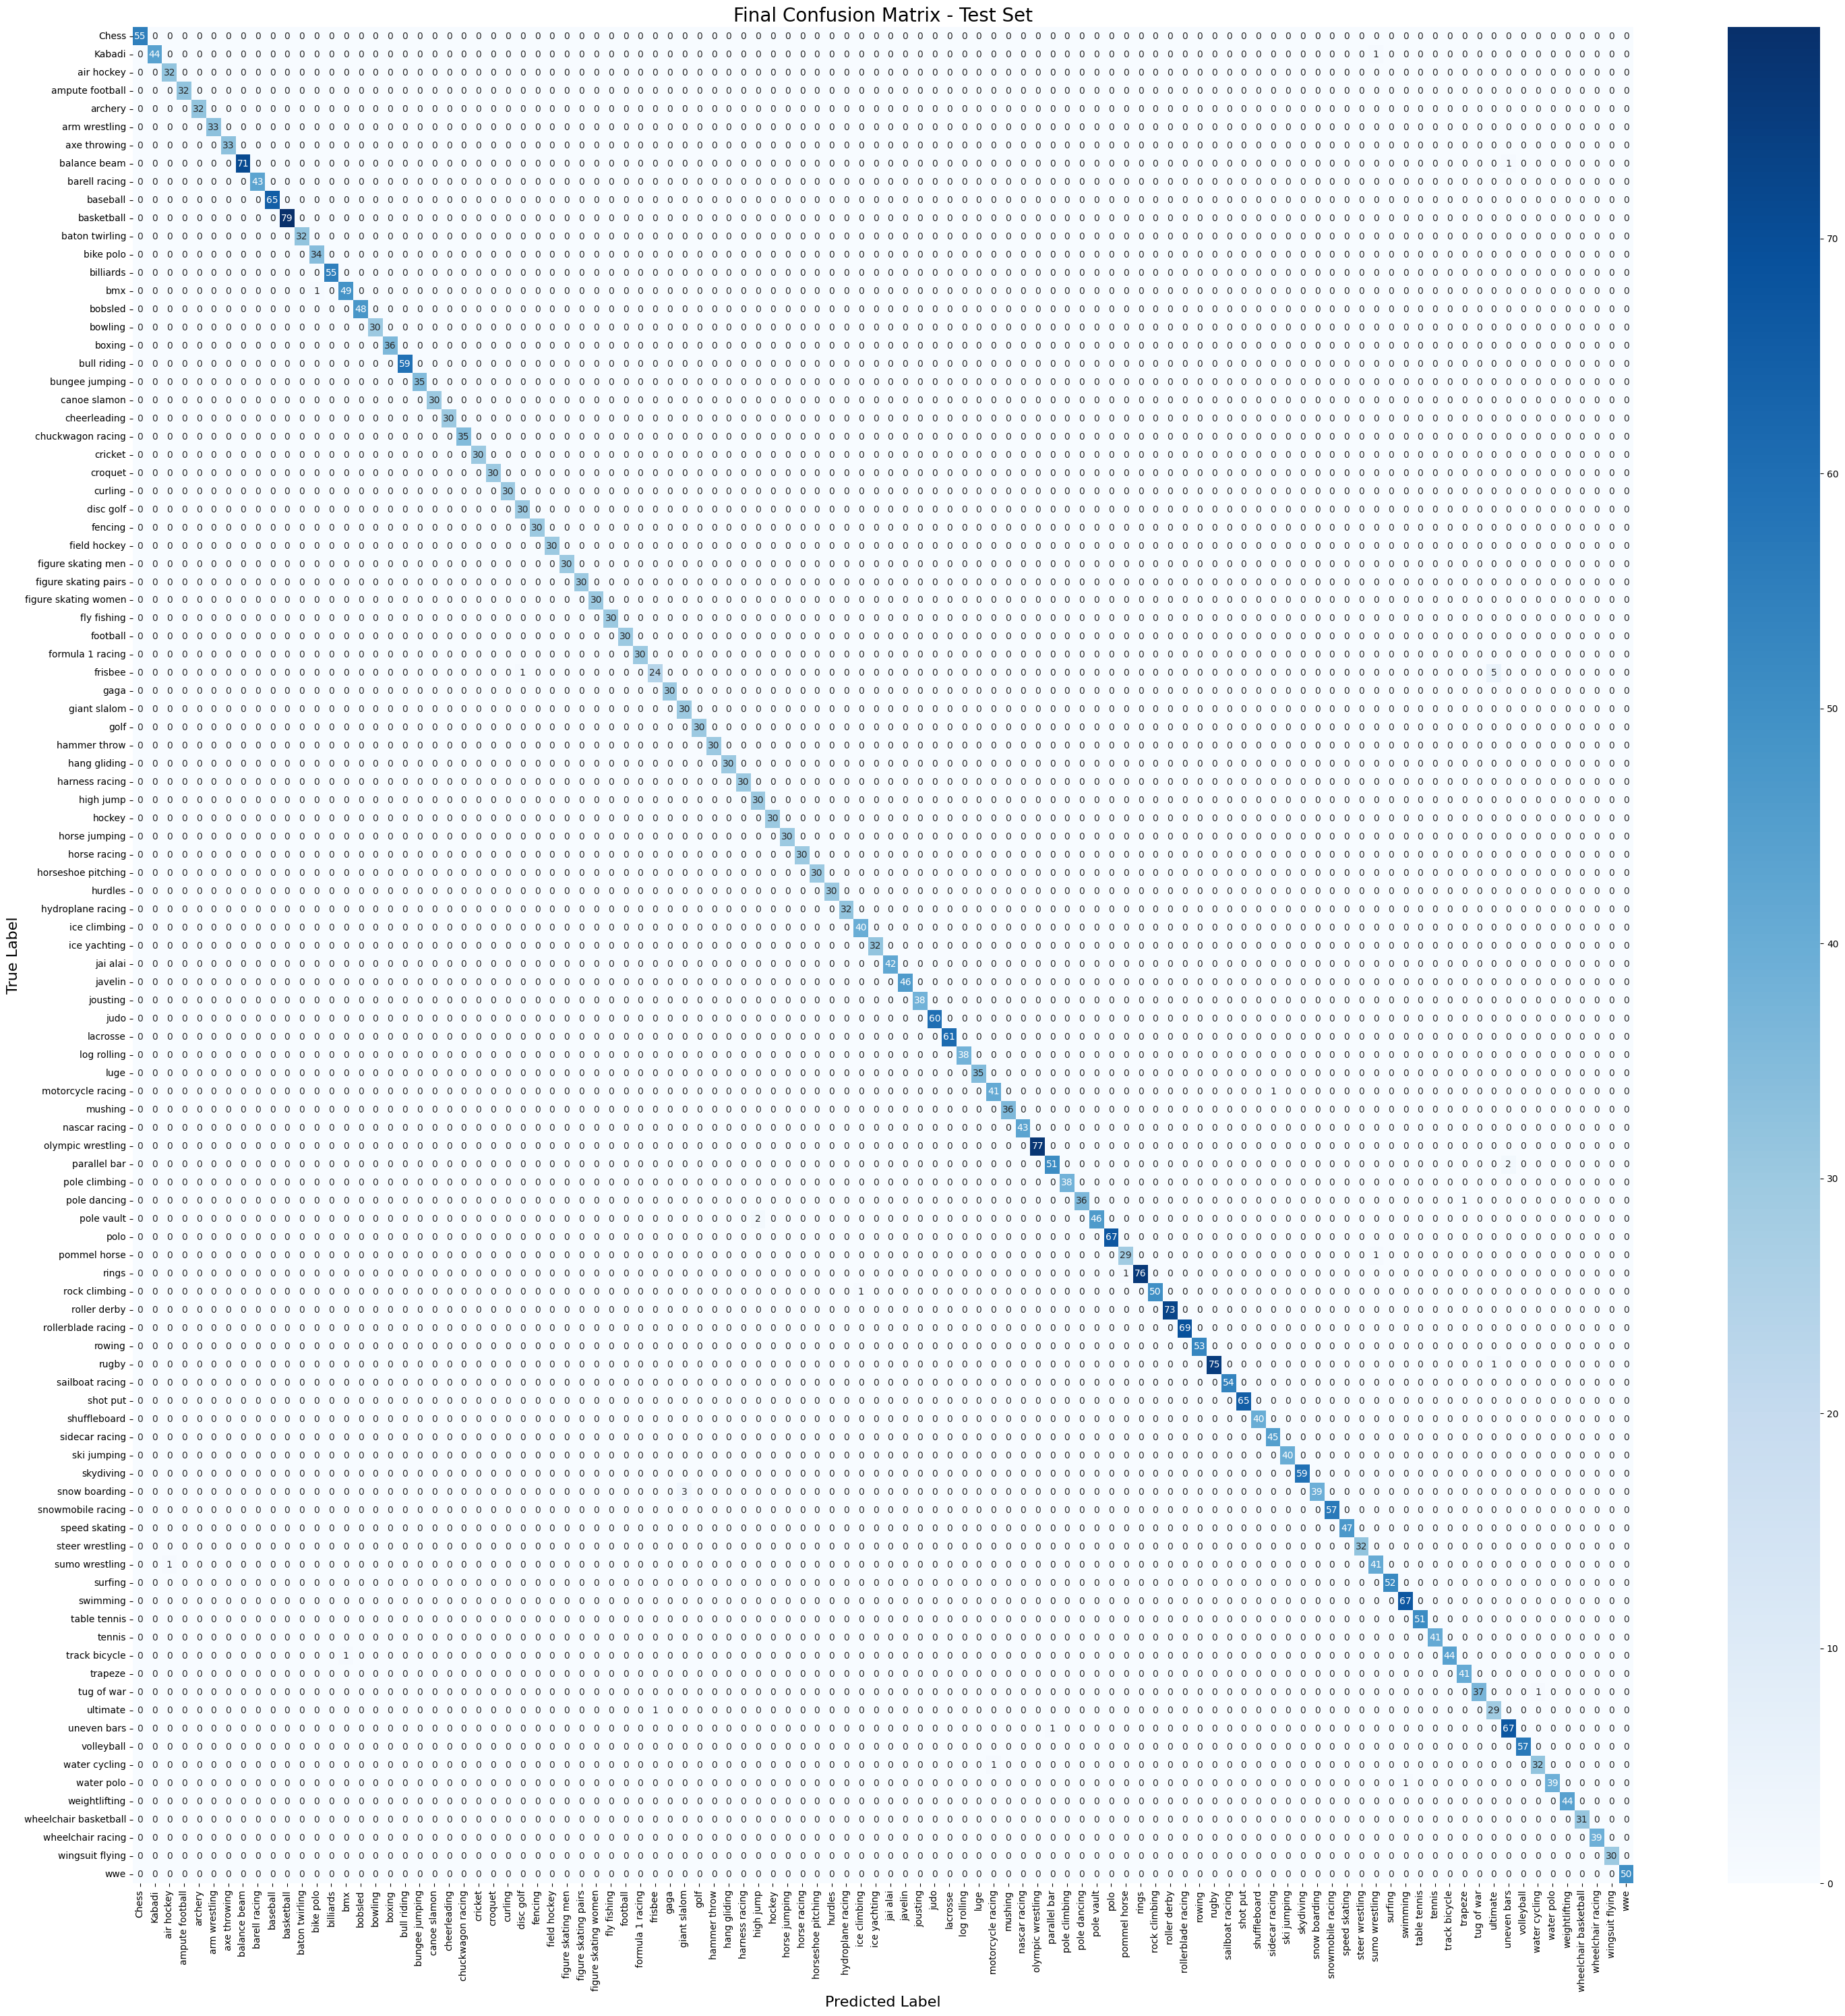

In [6]:
# ==============================================================================
# Cell 6: Final Evaluation and Reporting (Train, Val, & Test)
# ==============================================================================

print("\n--- Final Evaluation on All Datasets ---")

# First, load the state dictionary of the best performing model
state_dict = torch.load(best_model_path)

# Create a new instance of the model; this is important for a clean evaluation
eval_model = EVA02_Model(num_classes=NUM_CLASSES).to(DEVICE)

# Handle the 'module.' prefix if the model was saved from nn.DataParallel
if next(iter(state_dict)).startswith('module.'):
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    eval_model.load_state_dict(new_state_dict)
else:
    eval_model.load_state_dict(state_dict)

# Define the comprehensive evaluation and plotting functions
def evaluate(loader, model_to_eval, name):
    model_to_eval.eval()
    all_preds, all_labels = [], []
    with torch.no_grad(), torch.amp.autocast("cuda"):
        for images, labels in tqdm(loader, desc=f"Evaluating {name}"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            logits, _ = model_to_eval(images)
            predicted = logits.argmax(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    class_names = test_dataset.classes
    report = classification_report(all_labels, all_preds, output_dict=True, target_names=class_names)
    print(f"\n--- {name} Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    return report, all_labels, all_preds

def plot_confusion_matrix(y_true, y_pred, class_names, normalize=False, figsize=(30, 30)):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues", ax=ax)
    
    ax.set_title('Final Confusion Matrix - Test Set', fontsize=20)
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_ylabel('True Label', fontsize=16)
    ax.set_xticklabels(class_names, rotation=90)
    ax.set_yticklabels(class_names, rotation=0)
    
    plt.tight_layout()
    save_path = os.path.join(OUTPUT_DIR, "confusion_matrix.png")
    plt.savefig(save_path, dpi=300)
    print(f"\n✅ Confusion matrix saved to: {save_path}")
    plt.show()

# --- Run Evaluations ---
print("\nCreating a non-augmented training loader for evaluation...")
train_eval_dataset = Subset(full_train_dataset_no_aug, train_indices)
train_eval_loader = DataLoader(train_eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# FIXED: Added the missing 'eval_model' argument to all three calls
train_report, _, _ = evaluate(train_eval_loader, eval_model, "Train Set")
val_report, _, _ = evaluate(val_loader, eval_model, "Validation Set")
test_report, y_true, y_pred = evaluate(test_loader, eval_model, "Test Set")


# --- Final Summary ---
print("\n" + "="*30)
print("📊 FINAL ACCURACY SUMMARY 📊")
print("="*30)
print(f"Train Accuracy:      {train_report['accuracy']*100:.2f}%")
print(f"Validation Accuracy: {val_report['accuracy']*100:.2f}%")
print(f"Test Accuracy:       {test_report['accuracy']*100:.2f}%")
print("="*30)

# --- Generate Confusion Matrix for the Test Set ---
plot_confusion_matrix(y_true, y_pred, test_dataset.classes)

